In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

## Machine learning

In [4]:
from implementations import *

### Data pre-processing 

In [5]:
# putting the meaningless values to the median of the column
tX = np.where(tX==-999., np.nan,tX)
med_X = np.nanmedian(tX, axis=0)

inds = np.where(np.isnan(tX))
tX[inds] = np.take(med_X, inds[1])

In [6]:
print(np.where(tX[0] == 2))

(array([22], dtype=int64),)


In [7]:
# remove categorical data and standarize the rest
ntX = np.delete(tX, 22, axis=1)
ntX = np.apply_along_axis(standardize, 1, ntX)

### Exploratory analysis

### Feature processing

**Least squares**

In [8]:
(w_ls, loss_ls) = least_squares(y, ntX)
print(loss_ls)

0.33363954622100606


**Least squares with Gradient Descent**

In [23]:
#define parameters

initial_w = np.zeros(ntX.shape[1])
max_iters = 50
gamma = 0.05

(ws_gd, losses_gd) = least_squares_GD(y, ntX, initial_w, max_iters, gamma)

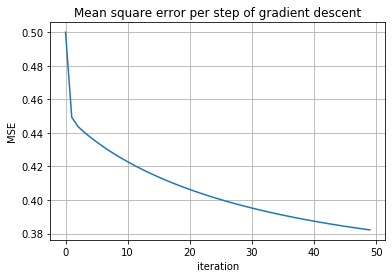

In [24]:
#plot the losses

fig, ax = plt.subplots()
ax.plot(range(max_iters), losses_gd)

ax.set(xlabel='iteration', ylabel='MSE',
       title='Mean square error per step of gradient descent')
ax.grid()
plt.show()

**Least squares with Stochastic Gradient Descent**

In [34]:
initial_w = np.zeros(ntX.shape[1])
max_iters = 100
gamma = 0.01

(ws_sgd, losses_sgd) = least_squares_SGD(y, ntX, initial_w, max_iters, gamma)

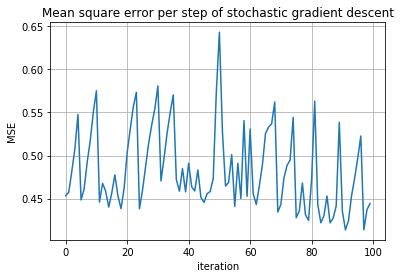

In [35]:
#plot the losses

fig, ax = plt.subplots()
ax.plot(range(max_iters), losses_sgd)

ax.set(xlabel='iteration', ylabel='MSE',
       title='Mean square error per step of stochastic gradient descent')
ax.grid()
plt.show()

**Ridge regression**

*Cross-validation hyperparameter selection*

In [36]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

In [37]:
seed = 1
degree = 7
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
#lambdas = [10e-03, 0,10e03 ]

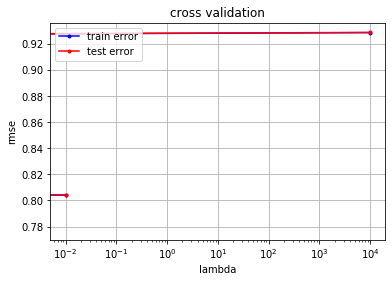

In [39]:
k_indices = build_k_indices(y, k_fold, seed)

rmse_tr = []
rmse_te = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(y, ntX, k_indices, k, lambda_, degree)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr.append(np.mean(l_rmse_tr))
    rmse_te.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

*Bias-variance decomposition for complexity determination*

In [40]:
def bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te):
    """visualize the bias variance decomposition."""
    rmse_tr_mean = np.expand_dims(np.mean(rmse_tr, axis=0), axis=0)
    rmse_te_mean = np.expand_dims(np.mean(rmse_te, axis=0), axis=0)
    plt.plot(degrees, rmse_tr.T, 'b', linestyle="-", color=([0.7, 0.7, 1]),
        label='train', linewidth=0.3)
    plt.plot(degrees, rmse_te.T, 'r', linestyle="-", color=[1, 0.7, 0.7], label='test', linewidth=0.3)
    plt.plot(degrees, rmse_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, rmse_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.ylim(0.2, 0.7)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")

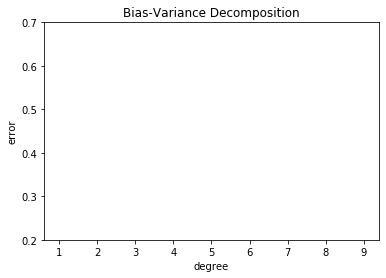

In [41]:
seeds = range(10)
ratio_train = 0.5
degrees = range(1, 10)

rmse_tr = np.empty((len(seeds), len(degrees)))
rmse_te = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(ntX, y, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = least_squares(y_tr, tx_tr)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

### Overfitting vs Underfitting

### Methods application and visualization

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)